In [1]:
!pip install WordCloud

You should consider upgrading via the 'c:\users\dávid\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


In [2]:
#import modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from ast import literal_eval


import warnings; warnings.simplefilter('ignore')


In [3]:
movies_df = pd.read_csv("G:\Study\Szakdolgozat\input\movies_metadata.csv")
movies_df.head()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [4]:
#The funcition input must be a list that contains a json's of genres, or empty, it takes out the name of each genre
def getGenres(row):
    if len(row) == 0:
        return []
    result = []
    eval_row = literal_eval(row)
    for item in eval_row:
        result.append(str.lower(item['name']))
    return result

In [5]:
movies_df['genres'] = movies_df['genres'].fillna("").apply(getGenres)
movies_df

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[animation, comedy, family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[adventure, fantasy, family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[romance, comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[comedy, drama, romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45461,False,NaN,0,"[drama, family]",http://www.imdb.com/title/tt6209470/,439050,tt6209470,fa,رگ خواب,Rising and falling between a man and woman.,...,NaN,0.0,90.0,"[{'iso_639_1': 'fa', 'name': 'فارسی'}]",Released,Rising and falling between a man and woman,Subdue,False,4.0,1.0
45462,False,NaN,0,[drama],NaN,111109,tt2028550,tl,Siglo ng Pagluluwal,An artist struggles to finish his work while a...,...,2011-11-17,0.0,360.0,"[{'iso_639_1': 'tl', 'name': ''}]",Released,NaN,Century of Birthing,False,9.0,3.0
45463,False,NaN,0,"[action, drama, thriller]",NaN,67758,tt0303758,en,Betrayal,"When one of her hits goes wrong, a professiona...",...,2003-08-01,0.0,90.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A deadly game of wits.,Betrayal,False,3.8,6.0
45464,False,NaN,0,[],NaN,227506,tt0008536,en,Satana likuyushchiy,"In a small town live two brothers, one a minis...",...,1917-10-21,0.0,87.0,[],Released,NaN,Satan Triumphant,False,0.0,0.0


In [6]:
#Since literal_eval not working correctly on collection row,had to parse it otherwise
#Making the belongs_to_collection column readable
import re

def getCollection(row):
    return str(re.findall("(?<='name':)(.*)',",row)).split(',')[0].split(']')[0][4:-1]


In [7]:
movies_df['belongs_to_collection'] = movies_df['belongs_to_collection'].fillna("").apply(lambda x : getCollection(str(x)))
movies_df

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,Toy Story Collection,30000000,"[animation, comedy, family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,,65000000,"[adventure, fantasy, family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,Grumpy Old Men Collection,0,"[romance, comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,,16000000,"[comedy, drama, romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,Father of the Bride Collection,0,[comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45461,False,,0,"[drama, family]",http://www.imdb.com/title/tt6209470/,439050,tt6209470,fa,رگ خواب,Rising and falling between a man and woman.,...,NaN,0.0,90.0,"[{'iso_639_1': 'fa', 'name': 'فارسی'}]",Released,Rising and falling between a man and woman,Subdue,False,4.0,1.0
45462,False,,0,[drama],NaN,111109,tt2028550,tl,Siglo ng Pagluluwal,An artist struggles to finish his work while a...,...,2011-11-17,0.0,360.0,"[{'iso_639_1': 'tl', 'name': ''}]",Released,NaN,Century of Birthing,False,9.0,3.0
45463,False,,0,"[action, drama, thriller]",NaN,67758,tt0303758,en,Betrayal,"When one of her hits goes wrong, a professiona...",...,2003-08-01,0.0,90.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A deadly game of wits.,Betrayal,False,3.8,6.0
45464,False,,0,[],NaN,227506,tt0008536,en,Satana likuyushchiy,"In a small town live two brothers, one a minis...",...,1917-10-21,0.0,87.0,[],Released,NaN,Satan Triumphant,False,0.0,0.0


In [8]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   adult                  45466 non-null  object 
 1   belongs_to_collection  45466 non-null  object 
 2   budget                 45466 non-null  object 
 3   genres                 45466 non-null  object 
 4   homepage               7782 non-null   object 
 5   id                     45466 non-null  object 
 6   imdb_id                45449 non-null  object 
 7   original_language      45455 non-null  object 
 8   original_title         45466 non-null  object 
 9   overview               44512 non-null  object 
 10  popularity             45461 non-null  object 
 11  poster_path            45080 non-null  object 
 12  production_companies   45463 non-null  object 
 13  production_countries   45463 non-null  object 
 14  release_date           45379 non-null  object 
 15  re

In [9]:
#Counting each Genre so we can later plot it

number_of_each_gen = {}
for row in movies_df['genres']:
    for genre in row:
        if genre in number_of_each_gen:
            number_of_each_gen[genre] += 1
        else:
            number_of_each_gen[genre] = 1
            
number_of_each_gen = dict(sorted(number_of_each_gen.items(), key=lambda item: item[1]))

<AxesSubplot:title={'center':'Number of each genres in the dataframe'}, xlabel='Genres', ylabel='Number_of_movies'>

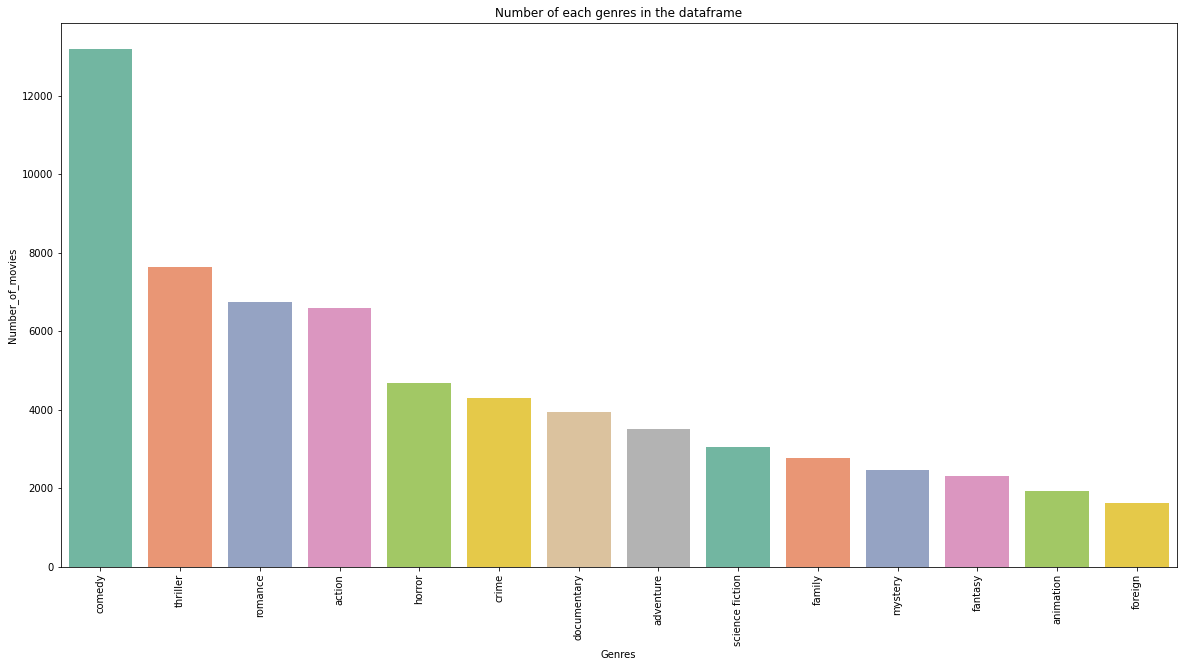

In [10]:
keys = list(number_of_each_gen.keys())[len(number_of_each_gen.keys())-15:-1]
keys.reverse()
values = [float(number_of_each_gen[k]) for k in keys]
fig, ax = plt.subplots(figsize=(20,10))
plt.title("Number of each genres in the dataframe")
plt.xticks(rotation = 90)
plt.ylabel('Number_of_movies')
plt.xlabel('Genres')
sns.barplot(x=keys, y=values,ax = ax,palette="Set2")

In [11]:
movies_df['release_year'] = movies_df['release_date'].apply(lambda date : np.nan if len(str(date)) < 10 else date[0:4])
movies_df

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,release_year
0,False,Toy Story Collection,30000000,"[animation, comedy, family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,1995
1,False,,65000000,"[adventure, fantasy, family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,1995
2,False,Grumpy Old Men Collection,0,"[romance, comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,1995
3,False,,16000000,"[comedy, drama, romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,1995
4,False,Father of the Bride Collection,0,[comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,1995
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45461,False,,0,"[drama, family]",http://www.imdb.com/title/tt6209470/,439050,tt6209470,fa,رگ خواب,Rising and falling between a man and woman.,...,0.0,90.0,"[{'iso_639_1': 'fa', 'name': 'فارسی'}]",Released,Rising and falling between a man and woman,Subdue,False,4.0,1.0,NaN
45462,False,,0,[drama],NaN,111109,tt2028550,tl,Siglo ng Pagluluwal,An artist struggles to finish his work while a...,...,0.0,360.0,"[{'iso_639_1': 'tl', 'name': ''}]",Released,NaN,Century of Birthing,False,9.0,3.0,2011
45463,False,,0,"[action, drama, thriller]",NaN,67758,tt0303758,en,Betrayal,"When one of her hits goes wrong, a professiona...",...,0.0,90.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A deadly game of wits.,Betrayal,False,3.8,6.0,2003
45464,False,,0,[],NaN,227506,tt0008536,en,Satana likuyushchiy,"In a small town live two brothers, one a minis...",...,0.0,87.0,[],Released,NaN,Satan Triumphant,False,0.0,0.0,1917


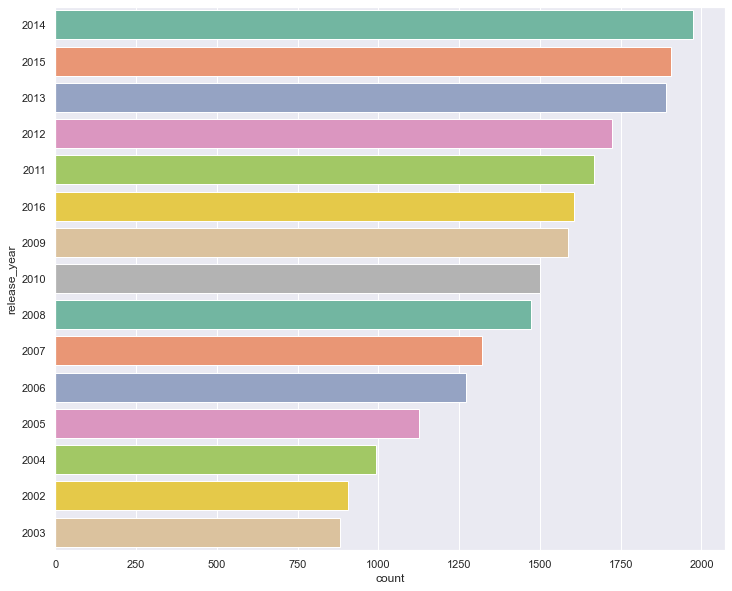

In [12]:
plt.figure(figsize=(12,10))
sns.set(style="darkgrid")
ax = sns.countplot(y='release_year', data=movies_df, palette="Set2", order=movies_df['release_year'].value_counts().index[0:15])

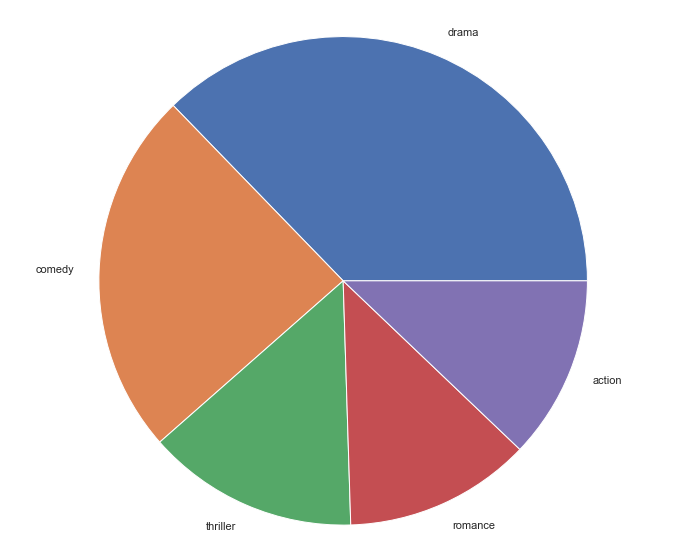

In [13]:
top_5_gen = sorted(number_of_each_gen.items(), key=lambda item : item[1],reverse=True)[0:5]
labels = []
values = []
for gen in top_5_gen:
    labels.append(gen[0])
    values.append(gen[1])

plt.figure(figsize=(12,10))
plt.pie(values, labels=labels)

plt.axis('equal')
plt.show()


In [14]:
movies_df = movies_df[movies_df['vote_count'].notnull()]

In [15]:
movies_df['vote_count'] = movies_df['vote_count'].astype(int)
movies_df = movies_df[movies_df['vote_count'] != 0]
movies_df['vote_average'] = movies_df['vote_average'].astype(int)
movies_df['id'] = movies_df['id'].astype(np.int64)

In [16]:
print(movies_df['vote_count'].describe(),'\n\n',movies_df['vote_average'].describe())

count    42561.000000
mean       117.382886
std        506.901699
min          1.000000
25%          4.000000
50%         11.000000
75%         38.000000
max      14075.000000
Name: vote_count, dtype: float64 

 count    42561.000000
mean         5.602148
std          1.312070
min          0.000000
25%          5.000000
50%          6.000000
75%          6.000000
max         10.000000
Name: vote_average, dtype: float64


In [17]:
def VoteCountGroup(value):
        if(0 < value <=50):
            return "Less than 50"
        elif(50<value<=100):
            return "More than 50 less than 101"
        elif(100<value<=300):
            return "More than 100 less than 300"
        elif(300<value<=800):
            return "More than 300 less than 800"
        elif(800<value<=1200):
            return "More than 800 less than 1200"
        elif(1200<value<=2000):
            return "More than 1200 less than 2000"
        elif(2000<value<=5000):
            return "More than 2000 less than 5000"
        elif(5000<value<=8000):
            return "More than 5000 less than 8000"
        elif(8000<value):
            return "More than 8000"

In [18]:
movies_df['vote_count_group'] = movies_df['vote_count'].fillna(0).apply(VoteCountGroup)

In [19]:
movies_df.groupby('vote_count_group').count()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,release_year
vote_count_group,,,,,,,,,,,,,,,,,,,,,
Less than 50,33513,33513,33513,33513,4695,33513,33502,33507,33513,32795,...,33513,33356,33513,33458,12744,33513,33513,33513,33513,33480
More than 100 less than 300,2988,2988,2988,2988,726,2988,2988,2988,2988,2977,...,2988,2988,2988,2988,2322,2988,2988,2988,2988,2988
More than 1200 less than 2000,426,426,426,426,234,426,426,426,426,426,...,426,426,426,426,421,426,426,426,426,426
More than 2000 less than 5000,411,411,411,411,288,411,411,411,411,411,...,411,411,411,411,402,411,411,411,411,411
More than 300 less than 800,1645,1645,1645,1645,618,1645,1645,1645,1645,1645,...,1645,1645,1645,1645,1492,1645,1645,1645,1645,1645
More than 50 less than 101,3028,3028,3028,3028,623,3028,3028,3028,3028,3004,...,3028,3027,3028,3027,1875,3028,3028,3028,3028,3027
More than 5000 less than 8000,79,79,79,79,73,79,79,79,79,79,...,79,79,79,79,77,79,79,79,79,79
More than 800 less than 1200,449,449,449,449,194,449,449,449,449,449,...,449,449,449,449,426,449,449,449,449,449
More than 8000,22,22,22,22,19,22,22,22,22,22,...,22,22,22,22,22,22,22,22,22,22


<AxesSubplot:xlabel='vote_count_group', ylabel='count'>

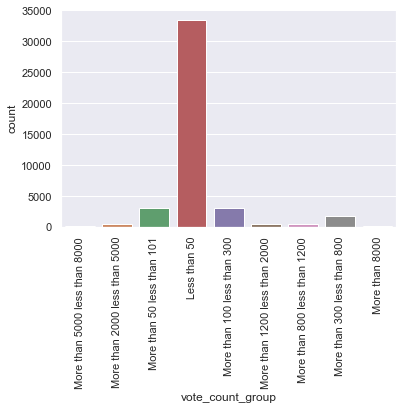

In [20]:
#Visualizing the 
plt.xticks(rotation = 90)
sns.countplot(x='vote_count_group',data = movies_df)

In [21]:
movies_df.groupby('vote_average').count()

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_count,release_year,vote_count_group
vote_average,,,,,,,,,,,,,,,,,,,,,
0,113,113,113,113,15,113,113,113,113,110,...,113,113,113,113,36,113,113,113,112,113
1,194,194,194,194,24,194,194,194,194,183,...,194,189,194,192,89,194,194,194,192,194
2,530,530,530,530,62,530,530,530,530,517,...,530,527,530,529,251,530,530,530,528,530
3,1614,1614,1614,1614,179,1614,1613,1614,1614,1579,...,1614,1609,1614,1608,834,1614,1614,1614,1612,1614
4,4538,4538,4538,4538,670,4538,4537,4537,4538,4447,...,4538,4515,4538,4534,2222,4538,4538,4538,4536,4538
5,11329,11329,11329,11329,1849,11329,11328,11327,11329,11139,...,11329,11305,11329,11317,5675,11329,11329,11329,11325,11329
6,14643,14643,14643,14643,2713,14643,14638,14640,14643,14422,...,14643,14596,14643,14627,6976,14643,14643,14643,14636,14643
7,7705,7705,7705,7705,1569,7705,7703,7705,7705,7584,...,7705,7670,7705,7698,3171,7705,7705,7705,7700,7705
8,1498,1498,1498,1498,312,1498,1498,1498,1498,1447,...,1498,1488,1498,1493,431,1498,1498,1498,1496,1498


<AxesSubplot:title={'center':'Movie vote average distribution'}, xlabel='vote_average', ylabel='count'>

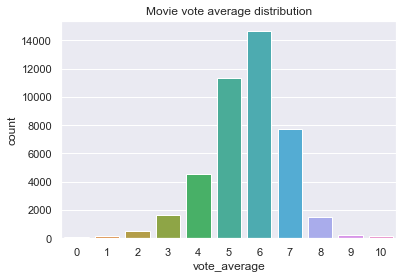

In [22]:
plt.title("Movie vote average distribution")
sns.countplot(x='vote_average',data = movies_df)

In [23]:
m = np.percentile(movies_df['vote_count'],80)
m

56.0

In [24]:
movies_df = movies_df[movies_df['vote_count'] >= m]
C = movies_df['vote_average'].mean()

In [25]:
#https://en.wikipedia.org/wiki/IMDb#Rankings
#W = R*v+C*m / v+m
#R Average vote value
#C Average vote value across the dataframe
#v Number of vote on a movie
#m Minimum nubmer of votes required

def Weightedratingv1(row):
    R = row['vote_average'] #Avarge vote value
    v = row['vote_count'] #Number of votes
    return ((R*v)/(v+m))+ ((C*m) / (v+m))
    

In [26]:
movies_df['WR'] = movies_df.apply(Weightedratingv1,axis = 1)
movies_df.shape

(8562, 27)

In [27]:
movies_df = movies_df[['id','belongs_to_collection','genres','original_title','overview','WR']]

In [28]:
movies_df["overview"] = movies_df["overview"].fillna("")

In [29]:
movies_df

,id,belongs_to_collection,genres,original_title,overview,WR
0,862,Toy Story Collection,"[animation, comedy, family]",Toy Story,"Led by Woody, Andy's toys live happily in his ...",6.988946
1,8844,,"[adventure, fantasy, family]",Jumanji,When siblings Judy and Peter discover an encha...,5.998188
2,15602,Grumpy Old Men Collection,"[romance, comedy]",Grumpier Old Men,A family wedding reignites the ancient feud be...,5.969772
4,11862,Father of the Bride Collection,[comedy],Father of the Bride Part II,Just when George Banks has recovered from his ...,5.225006
5,949,,"[action, crime, drama, thriller]",Heat,"Obsessive master thief, Neil McCauley leads a ...",6.968860
...,...,...,...,...,...,...
45268,277839,,[comedy],Pattaya,Franky and Krimo dream of leaving the grey gri...,5.246537
45339,430365,,[comedy],À bras ouverts,Jean-Étienne Fougerole is an intellectual bohe...,5.343509
45343,248705,The Visitors Collection,[comedy],Les Visiteurs: La Révolution,"Stuck in the corridors of time, Godefroy de Mo...",4.482181
45437,455661,,"[family, animation, romance, comedy]",In a Heartbeat,A closeted boy runs the risk of being outed by...,7.423397


In [30]:
keywords_df = pd.read_csv("G:\Study\Szakdolgozat\input\\keywords.csv")
keywords_df.head()

,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


In [31]:
#Input need to be a json like stuctor or empty
#Function collects into a list the keywords of a moive


def getKeywords(row):
    keywords = []
    if (len(row) == 0):
        return keywords
    else:
        for key in row:
            keywords.append(key["name"])
        return keywords
            

In [32]:
keywords_df["keywords"] = keywords_df["keywords"].fillna("").apply(literal_eval).apply(getKeywords)

In [33]:
credits_df = pd.read_csv("G:\Study\Szakdolgozat\input\\credits.csv")
credits_df.head()

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862


In [34]:
#Input need to be a json like stuctor or empty
def getCastMembers(row):
    castMembers = set()
    if len(row) == 0:
        return list(castMembers)
    else:
        for member in row:
            castMembers.add(str.lower(member['name']).replace(" ",""))
    return list(castMembers)

In [35]:
#Input need to be a json like stuctor or empty
def getCrewMembers(row,requestedRoles):
    crewMembers = set()
    if len(row) == 0:
        return list(crewMembers)
    else:
        for member in row:
            if member['job'] in requestedRoles:
                crewMembers.add(str.lower(member['name']).replace(" ",""))
    return list(crewMembers)

In [36]:
requestedRoles = ['Director','Screenplay','Producer','Executive Producer','Writer']
credits_df['cast'] = credits_df['cast'].fillna("").apply(literal_eval).apply(getCastMembers)
credits_df['crew'] = credits_df['crew'].fillna("").apply(literal_eval).apply(getCastMembers)
credits_df.head()

,cast,crew,id
0,"[jimvarney, anniepotts, donrickles, timallen, ...","[ashbrannon, kenwillard, jimmyhayward, sharonc...",862
1,"[adamhann-byrd, laurabellbundy, robinwilliams,...","[thomase.ackerman, robertdalva, jimstrain, sco...",8844
2,"[waltermatthau, kevinpollak, darylhannah, soph...","[markstevenjohnson, howarddeutch, jackkeller]",15602
3,"[wesleysnipes, lamontjohnson, gregoryhines, de...","[deborahschindler, ezraswerdlow, ronaldbass, k...",31357
4,"[petermichaelgoetz, kimberlywilliams-paisley, ...","[adambernardi, alberthackett, alansilvestri, n...",11862


In [37]:
movies_df = movies_df.merge(keywords_df,how='left',on='id')
movies_df = movies_df.merge(credits_df,how='left',on='id')
movies_df.head()

,id,belongs_to_collection,genres,original_title,overview,WR,keywords,cast,crew
0,862,Toy Story Collection,"[animation, comedy, family]",Toy Story,"Led by Woody, Andy's toys live happily in his ...",6.988946,"[jealousy, toy, boy, friendship, friends, riva...","[jimvarney, anniepotts, donrickles, timallen, ...","[ashbrannon, kenwillard, jimmyhayward, sharonc..."
1,8844,,"[adventure, fantasy, family]",Jumanji,When siblings Judy and Peter discover an encha...,5.998188,"[board game, disappearance, based on children'...","[adamhann-byrd, laurabellbundy, robinwilliams,...","[thomase.ackerman, robertdalva, jimstrain, sco..."
2,15602,Grumpy Old Men Collection,"[romance, comedy]",Grumpier Old Men,A family wedding reignites the ancient feud be...,5.969772,"[fishing, best friend, duringcreditsstinger, o...","[waltermatthau, kevinpollak, darylhannah, soph...","[markstevenjohnson, howarddeutch, jackkeller]"
3,11862,Father of the Bride Collection,[comedy],Father of the Bride Part II,Just when George Banks has recovered from his ...,5.225006,"[baby, midlife crisis, confidence, aging, daug...","[petermichaelgoetz, kimberlywilliams-paisley, ...","[adambernardi, alberthackett, alansilvestri, n..."
4,949,,"[action, crime, drama, thriller]",Heat,"Obsessive master thief, Neil McCauley leads a ...",6.968860,"[robbery, detective, bank, obsession, chase, s...","[kevingage, terrymiller, kimstaunton, darinman...","[artlinson, billabbott, anthonylattanzio, arno..."


In [38]:
movies_df.head()

,id,belongs_to_collection,genres,original_title,overview,WR,keywords,cast,crew
0,862,Toy Story Collection,"[animation, comedy, family]",Toy Story,"Led by Woody, Andy's toys live happily in his ...",6.988946,"[jealousy, toy, boy, friendship, friends, riva...","[jimvarney, anniepotts, donrickles, timallen, ...","[ashbrannon, kenwillard, jimmyhayward, sharonc..."
1,8844,,"[adventure, fantasy, family]",Jumanji,When siblings Judy and Peter discover an encha...,5.998188,"[board game, disappearance, based on children'...","[adamhann-byrd, laurabellbundy, robinwilliams,...","[thomase.ackerman, robertdalva, jimstrain, sco..."
2,15602,Grumpy Old Men Collection,"[romance, comedy]",Grumpier Old Men,A family wedding reignites the ancient feud be...,5.969772,"[fishing, best friend, duringcreditsstinger, o...","[waltermatthau, kevinpollak, darylhannah, soph...","[markstevenjohnson, howarddeutch, jackkeller]"
3,11862,Father of the Bride Collection,[comedy],Father of the Bride Part II,Just when George Banks has recovered from his ...,5.225006,"[baby, midlife crisis, confidence, aging, daug...","[petermichaelgoetz, kimberlywilliams-paisley, ...","[adambernardi, alberthackett, alansilvestri, n..."
4,949,,"[action, crime, drama, thriller]",Heat,"Obsessive master thief, Neil McCauley leads a ...",6.968860,"[robbery, detective, bank, obsession, chase, s...","[kevingage, terrymiller, kimstaunton, darinman...","[artlinson, billabbott, anthonylattanzio, arno..."


In [39]:
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer(language="english")

movies_df["keywords"] = movies_df["keywords"].fillna("").apply(lambda keywords : [stemmer.stem(keyword) for keyword in keywords]  if len(keywords) > 0 else [])

In [40]:
#Input needs to be a string
#Tokenize string into array of words
import string
from nltk.tokenize import word_tokenize


notWords = ["--","...","'s","''","n't","``",]
def tokenizeOverview(row):
    result = []
    words = word_tokenize(row)
    for word in words:
        if word not in string.punctuation and word not in notWords:
            result.append(word.lower())
    return result

In [41]:
movies_df['overview'] = movies_df['overview'].apply(tokenizeOverview)

In [42]:
movies_df['content'] = movies_df['genres'] + movies_df['overview'] + movies_df['keywords'] + movies_df['cast'] + movies_df['crew']
movies_df

,id,belongs_to_collection,genres,original_title,overview,WR,keywords,cast,crew,content
0,862,Toy Story Collection,"[animation, comedy, family]",Toy Story,"[led, by, woody, andy, toys, live, happily, in...",6.988946,"[jealousi, toy, boy, friendship, friend, rival...","[jimvarney, anniepotts, donrickles, timallen, ...","[ashbrannon, kenwillard, jimmyhayward, sharonc...","[animation, comedy, family, led, by, woody, an..."
1,8844,,"[adventure, fantasy, family]",Jumanji,"[when, siblings, judy, and, peter, discover, a...",5.998188,"[board gam, disappear, based on children's boo...","[adamhann-byrd, laurabellbundy, robinwilliams,...","[thomase.ackerman, robertdalva, jimstrain, sco...","[adventure, fantasy, family, when, siblings, j..."
2,15602,Grumpy Old Men Collection,"[romance, comedy]",Grumpier Old Men,"[a, family, wedding, reignites, the, ancient, ...",5.969772,"[fish, best friend, duringcreditssting, old men]","[waltermatthau, kevinpollak, darylhannah, soph...","[markstevenjohnson, howarddeutch, jackkeller]","[romance, comedy, a, family, wedding, reignite..."
3,11862,Father of the Bride Collection,[comedy],Father of the Bride Part II,"[just, when, george, banks, has, recovered, fr...",5.225006,"[babi, midlife crisi, confid, age, daughter, m...","[petermichaelgoetz, kimberlywilliams-paisley, ...","[adambernardi, alberthackett, alansilvestri, n...","[comedy, just, when, george, banks, has, recov..."
4,949,,"[action, crime, drama, thriller]",Heat,"[obsessive, master, thief, neil, mccauley, lea...",6.968860,"[robberi, detect, bank, obsess, chase, shoot, ...","[kevingage, terrymiller, kimstaunton, darinman...","[artlinson, billabbott, anthonylattanzio, arno...","[action, crime, drama, thriller, obsessive, ma..."
...,...,...,...,...,...,...,...,...,...,...
8691,277839,,[comedy],Pattaya,"[franky, and, krimo, dream, of, leaving, the, ...",5.246537,[],"[ismaëlsysavané, malikbentalha, doniaeden, set...","[stéphanekazandjian, renaudchassaing, arthurde...","[comedy, franky, and, krimo, dream, of, leavin..."
8692,430365,,[comedy],À bras ouverts,"[jean-étienne, fougerole, is, an, intellectual...",5.343509,[],"[aryabittan, cyrillecomte, nanougarcia, christ...","[philippedechauveron, christianclavier, marcde...","[comedy, jean-étienne, fougerole, is, an, inte..."
8693,248705,The Visitors Collection,[comedy],Les Visiteurs: La Révolution,"[stuck, in, the, corridors, of, time, godefroy...",4.482181,"[nazi, castl, time travel, robespierr]","[aryabittan, davidsalles, ryanbrodie, nicolasl...","[jean-mariepoiré, christianclavier]","[comedy, stuck, in, the, corridors, of, time, ..."
8694,455661,,"[family, animation, romance, comedy]",In a Heartbeat,"[a, closeted, boy, runs, the, risk, of, being,...",7.423397,"[love, teenag, lgbt, short]",[],"[bethdavid, arturocardelús, nickainsworth, lar...","[family, animation, romance, comedy, a, closet..."


In [43]:
movies_df['content']

0       [animation, comedy, family, led, by, woody, an...
1       [adventure, fantasy, family, when, siblings, j...
2       [romance, comedy, a, family, wedding, reignite...
3       [comedy, just, when, george, banks, has, recov...
4       [action, crime, drama, thriller, obsessive, ma...
                              ...                        
8691    [comedy, franky, and, krimo, dream, of, leavin...
8692    [comedy, jean-étienne, fougerole, is, an, inte...
8693    [comedy, stuck, in, the, corridors, of, time, ...
8694    [family, animation, romance, comedy, a, closet...
8695    [comedy, hyperactive, teenager, kelly, is, enr...
Name: content, Length: 8696, dtype: object

In [44]:
word_counter = {}
for row in movies_df['content']:
    for word in row:
        if word in word_counter:
            word_counter[word] += 1
        else:
            word_counter[word] = 1

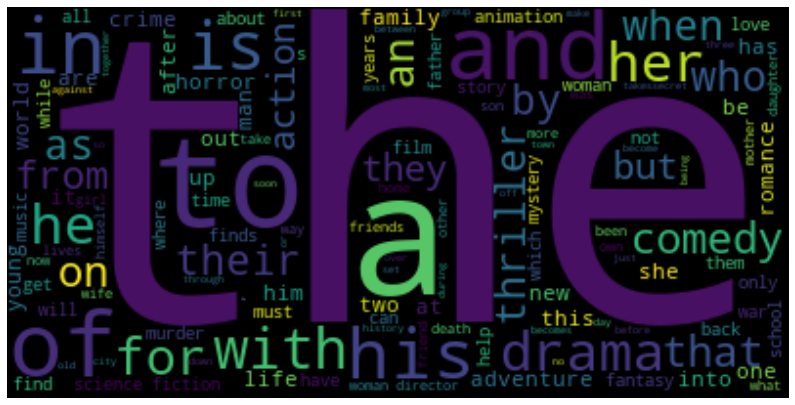

In [45]:
#http://librarycarpentry.org/lc-tdm/09-frequency-distributions/index.html
from wordcloud import WordCloud

cloud = WordCloud(max_font_size=500).generate_from_frequencies(word_counter)
plt.figure(figsize=(14,12))
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [46]:
similarity_matrix = np.array(np.zeros((movies_df.shape[0],movies_df.shape[0]),float))

In [47]:
#https://paulminogue.com/index.php/2019/09/29/introduction-to-cosine-similarity/
def similarity_bag_of_words(movie_1,movie_2):
    word_position = {}
    index = 0
    for word in movie_1:
        if word not in word_position:
            word_position[word] = index
            index += 1
    for word in movie_2:
        if word not in word_position:
            word_position[word] = index
            index += 1
            
    vec1 = np.array(np.zeros(len(word_position),int))
    vec2 = np.array(np.zeros(len(word_position),int))
    for word in movie_1:
        vec1[word_position[word]] += 1
        
    for word in movie_2:
        vec2[word_position[word]] += 1
        
    
    return np.dot(vec1,vec2)/(np.linalg.norm(vec1)*np.linalg.norm(vec2))

In [48]:
import os
import pickle
if(os.path.isfile('input/content_sim_cache.pickle')):
    infile = open('input/content_sim_cache.pickle','rb')
    similarity_matrix = pickle.load(infile)
    infile.close()
else:
    for i in range(int(len(movies_df['content'])/2)):
        for j in range(len(movies_df['content'])):
            tmp = similarity_bag_of_words(movies_df['content'].iloc[i],movies_df['content'].iloc[j])
            similarity_matrix[i][j] = tmp
            similarity_matrix[j][i] = tmp
        print(i,"is done out of: ",len(movies_df['content'])/2)

0 is done out of:  4348.0
1 is done out of:  4348.0
2 is done out of:  4348.0
3 is done out of:  4348.0
4 is done out of:  4348.0
5 is done out of:  4348.0
6 is done out of:  4348.0
7 is done out of:  4348.0
8 is done out of:  4348.0
9 is done out of:  4348.0
10 is done out of:  4348.0
11 is done out of:  4348.0
12 is done out of:  4348.0
13 is done out of:  4348.0
14 is done out of:  4348.0
15 is done out of:  4348.0
16 is done out of:  4348.0
17 is done out of:  4348.0
18 is done out of:  4348.0
19 is done out of:  4348.0
20 is done out of:  4348.0
21 is done out of:  4348.0
22 is done out of:  4348.0
23 is done out of:  4348.0
24 is done out of:  4348.0
25 is done out of:  4348.0
26 is done out of:  4348.0
27 is done out of:  4348.0
28 is done out of:  4348.0
29 is done out of:  4348.0
30 is done out of:  4348.0
31 is done out of:  4348.0
32 is done out of:  4348.0
33 is done out of:  4348.0
34 is done out of:  4348.0
35 is done out of:  4348.0
36 is done out of:  4348.0
37 is done 

297 is done out of:  4348.0
298 is done out of:  4348.0
299 is done out of:  4348.0
300 is done out of:  4348.0
301 is done out of:  4348.0
302 is done out of:  4348.0
303 is done out of:  4348.0
304 is done out of:  4348.0
305 is done out of:  4348.0
306 is done out of:  4348.0
307 is done out of:  4348.0
308 is done out of:  4348.0
309 is done out of:  4348.0
310 is done out of:  4348.0
311 is done out of:  4348.0
312 is done out of:  4348.0
313 is done out of:  4348.0
314 is done out of:  4348.0
315 is done out of:  4348.0
316 is done out of:  4348.0
317 is done out of:  4348.0
318 is done out of:  4348.0
319 is done out of:  4348.0
320 is done out of:  4348.0
321 is done out of:  4348.0
322 is done out of:  4348.0
323 is done out of:  4348.0
324 is done out of:  4348.0
325 is done out of:  4348.0
326 is done out of:  4348.0
327 is done out of:  4348.0
328 is done out of:  4348.0
329 is done out of:  4348.0
330 is done out of:  4348.0
331 is done out of:  4348.0
332 is done out of: 

590 is done out of:  4348.0
591 is done out of:  4348.0
592 is done out of:  4348.0
593 is done out of:  4348.0
594 is done out of:  4348.0
595 is done out of:  4348.0
596 is done out of:  4348.0
597 is done out of:  4348.0
598 is done out of:  4348.0
599 is done out of:  4348.0
600 is done out of:  4348.0
601 is done out of:  4348.0
602 is done out of:  4348.0
603 is done out of:  4348.0
604 is done out of:  4348.0
605 is done out of:  4348.0
606 is done out of:  4348.0
607 is done out of:  4348.0
608 is done out of:  4348.0
609 is done out of:  4348.0
610 is done out of:  4348.0
611 is done out of:  4348.0
612 is done out of:  4348.0
613 is done out of:  4348.0
614 is done out of:  4348.0
615 is done out of:  4348.0
616 is done out of:  4348.0
617 is done out of:  4348.0
618 is done out of:  4348.0
619 is done out of:  4348.0
620 is done out of:  4348.0
621 is done out of:  4348.0
622 is done out of:  4348.0
623 is done out of:  4348.0
624 is done out of:  4348.0
625 is done out of: 

883 is done out of:  4348.0
884 is done out of:  4348.0
885 is done out of:  4348.0
886 is done out of:  4348.0
887 is done out of:  4348.0
888 is done out of:  4348.0
889 is done out of:  4348.0
890 is done out of:  4348.0
891 is done out of:  4348.0
892 is done out of:  4348.0
893 is done out of:  4348.0
894 is done out of:  4348.0
895 is done out of:  4348.0
896 is done out of:  4348.0
897 is done out of:  4348.0
898 is done out of:  4348.0
899 is done out of:  4348.0
900 is done out of:  4348.0
901 is done out of:  4348.0
902 is done out of:  4348.0
903 is done out of:  4348.0
904 is done out of:  4348.0
905 is done out of:  4348.0
906 is done out of:  4348.0
907 is done out of:  4348.0
908 is done out of:  4348.0
909 is done out of:  4348.0
910 is done out of:  4348.0
911 is done out of:  4348.0
912 is done out of:  4348.0
913 is done out of:  4348.0
914 is done out of:  4348.0
915 is done out of:  4348.0
916 is done out of:  4348.0
917 is done out of:  4348.0
918 is done out of: 

1170 is done out of:  4348.0
1171 is done out of:  4348.0
1172 is done out of:  4348.0
1173 is done out of:  4348.0
1174 is done out of:  4348.0
1175 is done out of:  4348.0
1176 is done out of:  4348.0
1177 is done out of:  4348.0
1178 is done out of:  4348.0
1179 is done out of:  4348.0
1180 is done out of:  4348.0
1181 is done out of:  4348.0
1182 is done out of:  4348.0
1183 is done out of:  4348.0
1184 is done out of:  4348.0
1185 is done out of:  4348.0
1186 is done out of:  4348.0
1187 is done out of:  4348.0
1188 is done out of:  4348.0
1189 is done out of:  4348.0
1190 is done out of:  4348.0
1191 is done out of:  4348.0
1192 is done out of:  4348.0
1193 is done out of:  4348.0
1194 is done out of:  4348.0
1195 is done out of:  4348.0
1196 is done out of:  4348.0
1197 is done out of:  4348.0
1198 is done out of:  4348.0
1199 is done out of:  4348.0
1200 is done out of:  4348.0
1201 is done out of:  4348.0
1202 is done out of:  4348.0
1203 is done out of:  4348.0
1204 is done o

1453 is done out of:  4348.0
1454 is done out of:  4348.0
1455 is done out of:  4348.0
1456 is done out of:  4348.0
1457 is done out of:  4348.0
1458 is done out of:  4348.0
1459 is done out of:  4348.0
1460 is done out of:  4348.0
1461 is done out of:  4348.0
1462 is done out of:  4348.0
1463 is done out of:  4348.0
1464 is done out of:  4348.0
1465 is done out of:  4348.0
1466 is done out of:  4348.0
1467 is done out of:  4348.0
1468 is done out of:  4348.0
1469 is done out of:  4348.0
1470 is done out of:  4348.0
1471 is done out of:  4348.0
1472 is done out of:  4348.0
1473 is done out of:  4348.0
1474 is done out of:  4348.0
1475 is done out of:  4348.0
1476 is done out of:  4348.0
1477 is done out of:  4348.0
1478 is done out of:  4348.0
1479 is done out of:  4348.0
1480 is done out of:  4348.0
1481 is done out of:  4348.0
1482 is done out of:  4348.0
1483 is done out of:  4348.0
1484 is done out of:  4348.0
1485 is done out of:  4348.0
1486 is done out of:  4348.0
1487 is done o

1736 is done out of:  4348.0
1737 is done out of:  4348.0
1738 is done out of:  4348.0
1739 is done out of:  4348.0
1740 is done out of:  4348.0
1741 is done out of:  4348.0
1742 is done out of:  4348.0
1743 is done out of:  4348.0
1744 is done out of:  4348.0
1745 is done out of:  4348.0
1746 is done out of:  4348.0
1747 is done out of:  4348.0
1748 is done out of:  4348.0
1749 is done out of:  4348.0
1750 is done out of:  4348.0
1751 is done out of:  4348.0
1752 is done out of:  4348.0
1753 is done out of:  4348.0
1754 is done out of:  4348.0
1755 is done out of:  4348.0
1756 is done out of:  4348.0
1757 is done out of:  4348.0
1758 is done out of:  4348.0
1759 is done out of:  4348.0
1760 is done out of:  4348.0
1761 is done out of:  4348.0
1762 is done out of:  4348.0
1763 is done out of:  4348.0
1764 is done out of:  4348.0
1765 is done out of:  4348.0
1766 is done out of:  4348.0
1767 is done out of:  4348.0
1768 is done out of:  4348.0
1769 is done out of:  4348.0
1770 is done o

2019 is done out of:  4348.0
2020 is done out of:  4348.0
2021 is done out of:  4348.0
2022 is done out of:  4348.0
2023 is done out of:  4348.0
2024 is done out of:  4348.0
2025 is done out of:  4348.0
2026 is done out of:  4348.0
2027 is done out of:  4348.0
2028 is done out of:  4348.0
2029 is done out of:  4348.0
2030 is done out of:  4348.0
2031 is done out of:  4348.0
2032 is done out of:  4348.0
2033 is done out of:  4348.0
2034 is done out of:  4348.0
2035 is done out of:  4348.0
2036 is done out of:  4348.0
2037 is done out of:  4348.0
2038 is done out of:  4348.0
2039 is done out of:  4348.0
2040 is done out of:  4348.0
2041 is done out of:  4348.0
2042 is done out of:  4348.0
2043 is done out of:  4348.0
2044 is done out of:  4348.0
2045 is done out of:  4348.0
2046 is done out of:  4348.0
2047 is done out of:  4348.0
2048 is done out of:  4348.0
2049 is done out of:  4348.0
2050 is done out of:  4348.0
2051 is done out of:  4348.0
2052 is done out of:  4348.0
2053 is done o

2302 is done out of:  4348.0
2303 is done out of:  4348.0
2304 is done out of:  4348.0
2305 is done out of:  4348.0
2306 is done out of:  4348.0
2307 is done out of:  4348.0
2308 is done out of:  4348.0
2309 is done out of:  4348.0
2310 is done out of:  4348.0
2311 is done out of:  4348.0
2312 is done out of:  4348.0
2313 is done out of:  4348.0
2314 is done out of:  4348.0
2315 is done out of:  4348.0
2316 is done out of:  4348.0
2317 is done out of:  4348.0
2318 is done out of:  4348.0
2319 is done out of:  4348.0
2320 is done out of:  4348.0
2321 is done out of:  4348.0
2322 is done out of:  4348.0
2323 is done out of:  4348.0
2324 is done out of:  4348.0
2325 is done out of:  4348.0
2326 is done out of:  4348.0
2327 is done out of:  4348.0
2328 is done out of:  4348.0
2329 is done out of:  4348.0
2330 is done out of:  4348.0
2331 is done out of:  4348.0
2332 is done out of:  4348.0
2333 is done out of:  4348.0
2334 is done out of:  4348.0
2335 is done out of:  4348.0
2336 is done o

2585 is done out of:  4348.0
2586 is done out of:  4348.0
2587 is done out of:  4348.0
2588 is done out of:  4348.0
2589 is done out of:  4348.0
2590 is done out of:  4348.0
2591 is done out of:  4348.0
2592 is done out of:  4348.0
2593 is done out of:  4348.0
2594 is done out of:  4348.0
2595 is done out of:  4348.0
2596 is done out of:  4348.0
2597 is done out of:  4348.0
2598 is done out of:  4348.0
2599 is done out of:  4348.0
2600 is done out of:  4348.0
2601 is done out of:  4348.0
2602 is done out of:  4348.0
2603 is done out of:  4348.0
2604 is done out of:  4348.0
2605 is done out of:  4348.0
2606 is done out of:  4348.0
2607 is done out of:  4348.0
2608 is done out of:  4348.0
2609 is done out of:  4348.0
2610 is done out of:  4348.0
2611 is done out of:  4348.0
2612 is done out of:  4348.0
2613 is done out of:  4348.0
2614 is done out of:  4348.0
2615 is done out of:  4348.0
2616 is done out of:  4348.0
2617 is done out of:  4348.0
2618 is done out of:  4348.0
2619 is done o

2868 is done out of:  4348.0
2869 is done out of:  4348.0
2870 is done out of:  4348.0
2871 is done out of:  4348.0
2872 is done out of:  4348.0
2873 is done out of:  4348.0
2874 is done out of:  4348.0
2875 is done out of:  4348.0
2876 is done out of:  4348.0
2877 is done out of:  4348.0
2878 is done out of:  4348.0
2879 is done out of:  4348.0
2880 is done out of:  4348.0
2881 is done out of:  4348.0
2882 is done out of:  4348.0
2883 is done out of:  4348.0
2884 is done out of:  4348.0
2885 is done out of:  4348.0
2886 is done out of:  4348.0
2887 is done out of:  4348.0
2888 is done out of:  4348.0
2889 is done out of:  4348.0
2890 is done out of:  4348.0
2891 is done out of:  4348.0
2892 is done out of:  4348.0
2893 is done out of:  4348.0
2894 is done out of:  4348.0
2895 is done out of:  4348.0
2896 is done out of:  4348.0
2897 is done out of:  4348.0
2898 is done out of:  4348.0
2899 is done out of:  4348.0
2900 is done out of:  4348.0
2901 is done out of:  4348.0
2902 is done o

3151 is done out of:  4348.0
3152 is done out of:  4348.0
3153 is done out of:  4348.0
3154 is done out of:  4348.0
3155 is done out of:  4348.0
3156 is done out of:  4348.0
3157 is done out of:  4348.0
3158 is done out of:  4348.0
3159 is done out of:  4348.0
3160 is done out of:  4348.0
3161 is done out of:  4348.0
3162 is done out of:  4348.0
3163 is done out of:  4348.0
3164 is done out of:  4348.0
3165 is done out of:  4348.0
3166 is done out of:  4348.0
3167 is done out of:  4348.0
3168 is done out of:  4348.0
3169 is done out of:  4348.0
3170 is done out of:  4348.0
3171 is done out of:  4348.0
3172 is done out of:  4348.0
3173 is done out of:  4348.0
3174 is done out of:  4348.0
3175 is done out of:  4348.0
3176 is done out of:  4348.0
3177 is done out of:  4348.0
3178 is done out of:  4348.0
3179 is done out of:  4348.0
3180 is done out of:  4348.0
3181 is done out of:  4348.0
3182 is done out of:  4348.0
3183 is done out of:  4348.0
3184 is done out of:  4348.0
3185 is done o

3434 is done out of:  4348.0
3435 is done out of:  4348.0
3436 is done out of:  4348.0
3437 is done out of:  4348.0
3438 is done out of:  4348.0
3439 is done out of:  4348.0
3440 is done out of:  4348.0
3441 is done out of:  4348.0
3442 is done out of:  4348.0
3443 is done out of:  4348.0
3444 is done out of:  4348.0
3445 is done out of:  4348.0
3446 is done out of:  4348.0
3447 is done out of:  4348.0
3448 is done out of:  4348.0
3449 is done out of:  4348.0
3450 is done out of:  4348.0
3451 is done out of:  4348.0
3452 is done out of:  4348.0
3453 is done out of:  4348.0
3454 is done out of:  4348.0
3455 is done out of:  4348.0
3456 is done out of:  4348.0
3457 is done out of:  4348.0
3458 is done out of:  4348.0
3459 is done out of:  4348.0
3460 is done out of:  4348.0
3461 is done out of:  4348.0
3462 is done out of:  4348.0
3463 is done out of:  4348.0
3464 is done out of:  4348.0
3465 is done out of:  4348.0
3466 is done out of:  4348.0
3467 is done out of:  4348.0
3468 is done o

3717 is done out of:  4348.0
3718 is done out of:  4348.0
3719 is done out of:  4348.0
3720 is done out of:  4348.0
3721 is done out of:  4348.0
3722 is done out of:  4348.0
3723 is done out of:  4348.0
3724 is done out of:  4348.0
3725 is done out of:  4348.0
3726 is done out of:  4348.0
3727 is done out of:  4348.0
3728 is done out of:  4348.0
3729 is done out of:  4348.0
3730 is done out of:  4348.0
3731 is done out of:  4348.0
3732 is done out of:  4348.0
3733 is done out of:  4348.0
3734 is done out of:  4348.0
3735 is done out of:  4348.0
3736 is done out of:  4348.0
3737 is done out of:  4348.0
3738 is done out of:  4348.0
3739 is done out of:  4348.0
3740 is done out of:  4348.0
3741 is done out of:  4348.0
3742 is done out of:  4348.0
3743 is done out of:  4348.0
3744 is done out of:  4348.0
3745 is done out of:  4348.0
3746 is done out of:  4348.0
3747 is done out of:  4348.0
3748 is done out of:  4348.0
3749 is done out of:  4348.0
3750 is done out of:  4348.0
3751 is done o

4000 is done out of:  4348.0
4001 is done out of:  4348.0
4002 is done out of:  4348.0
4003 is done out of:  4348.0
4004 is done out of:  4348.0
4005 is done out of:  4348.0
4006 is done out of:  4348.0
4007 is done out of:  4348.0
4008 is done out of:  4348.0
4009 is done out of:  4348.0
4010 is done out of:  4348.0
4011 is done out of:  4348.0
4012 is done out of:  4348.0
4013 is done out of:  4348.0
4014 is done out of:  4348.0
4015 is done out of:  4348.0
4016 is done out of:  4348.0
4017 is done out of:  4348.0
4018 is done out of:  4348.0
4019 is done out of:  4348.0
4020 is done out of:  4348.0
4021 is done out of:  4348.0
4022 is done out of:  4348.0
4023 is done out of:  4348.0
4024 is done out of:  4348.0
4025 is done out of:  4348.0
4026 is done out of:  4348.0
4027 is done out of:  4348.0
4028 is done out of:  4348.0
4029 is done out of:  4348.0
4030 is done out of:  4348.0
4031 is done out of:  4348.0
4032 is done out of:  4348.0
4033 is done out of:  4348.0
4034 is done o

4283 is done out of:  4348.0
4284 is done out of:  4348.0
4285 is done out of:  4348.0
4286 is done out of:  4348.0
4287 is done out of:  4348.0
4288 is done out of:  4348.0
4289 is done out of:  4348.0
4290 is done out of:  4348.0
4291 is done out of:  4348.0
4292 is done out of:  4348.0
4293 is done out of:  4348.0
4294 is done out of:  4348.0
4295 is done out of:  4348.0
4296 is done out of:  4348.0
4297 is done out of:  4348.0
4298 is done out of:  4348.0
4299 is done out of:  4348.0
4300 is done out of:  4348.0
4301 is done out of:  4348.0
4302 is done out of:  4348.0
4303 is done out of:  4348.0
4304 is done out of:  4348.0
4305 is done out of:  4348.0
4306 is done out of:  4348.0
4307 is done out of:  4348.0
4308 is done out of:  4348.0
4309 is done out of:  4348.0
4310 is done out of:  4348.0
4311 is done out of:  4348.0
4312 is done out of:  4348.0
4313 is done out of:  4348.0
4314 is done out of:  4348.0
4315 is done out of:  4348.0
4316 is done out of:  4348.0
4317 is done o

In [49]:
similarity_matrix

array([[1.        , 0.09679387, 0.11467133, ..., 0.15760404, 0.19767387,
        0.09331542],
       [0.09679387, 1.        , 0.19391447, ..., 0.19529164, 0.11275168,
        0.15648564],
       [0.11467133, 0.19391447, 1.        , ..., 0.2903357 , 0.18857857,
        0.31157638],
       ...,
       [0.15760404, 0.19529164, 0.2903357 , ..., 0.        , 0.        ,
        0.        ],
       [0.19767387, 0.11275168, 0.18857857, ..., 0.        , 0.        ,
        0.        ],
       [0.09331542, 0.15648564, 0.31157638, ..., 0.        , 0.        ,
        0.        ]])

In [50]:
import pickle
##Caching 
cache = pd.Series(list(similarity_matrix))
outfile = open('input/content_sim_cache.pickle','wb')
pickle.dump(cache,outfile)
outfile.close()



In [51]:
movies_to_index = {}

for i,title in enumerate (movies_df['original_title']):
    movies_to_index[title] = i

In [52]:
def ContentBasedRecommendation(movie):
    index_of_movies = {}
    for i, sim in enumerate(similarity_matrix[movies_to_index[movie]]):
        index_of_movies[i] = sim
    index_of_movies = sorted(index_of_movies.items(), key=lambda item : item[1],reverse=True)[1:10]
    reccomendations = [movies_df.iloc[i]['original_title'] for i,_ in index_of_movies ]
    print(reccomendations)

In [53]:
ContentBasedRecommendation('Jumanji')

['Stay Alive', 'The Land Before Time IV: Journey Through the Mists', 'Viy', 'Indie Game: The Movie', 'Jin Yi Wei', 'Backmask', 'Digimon: The Movie', 'Brainscan', '劇場版ポケットモンスター セレビィ 時を越えた遭遇（であい）']
